In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
from sklearn.linear_model import LinearRegression

In [ ]:
sfh_all = pd.read_csv('data/sfhousing.csv', on_bad_lines='skip')


def make_lamorinda(sfh):
    return sfh.replace({
        'city': {
            'Lafayette': 'Lamorinda',
            'Moraga': 'Lamorinda',
            'Orinda': 'Lamorinda',
        }
    })

four_cities = ['Berkeley', 'Lamorinda', 'Piedmont', 'Richmond']

def parse_dates(sfh):
    dates = pd.to_datetime(sfh['date'], format='%Y-%m-%d')
    return sfh.assign(dates=dates).set_index('date')


def subset(df):
    return df.loc[(df['price'] < 4000000) &
                  (df['bsqft'] < 12000) &
                  (df['lsqft'] < 100000) &
                  (df['city'].str.contains("Berkeley|Piedmont|Richmond|Lamorinda")) &
                  (df['dates'] > '2005-12-31') &
                  (df['dates'] <= '2006-12-31')
                 ]

def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    six_up = sfh.loc[sfh['br'] >=6, 'br'].unique()
    new_bed = sfh['br'].replace(six_up, 6)
    return sfh.assign(br=new_bed)

def compute_ppsf(sfh):
    return sfh.assign(
    ppsf=sfh['price'] / sfh['bsqft'], 
    log_ppsf=lambda df: np.log10(df['ppsf']))


sfh = (sfh_all
 .pipe(make_lamorinda)
 .pipe(parse_dates)
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
 .pipe(compute_ppsf) 
)

In [4]:
var_na = ['log_price', 'log_lsqft', 'log_bsqft', 'br']
sfh = sfh.dropna(subset=var_na)
sfh.drop(["dates","county", "zip","street","year","datesold"], axis=1, inplace=True)

# Feature Engineering for Categorical Measurements 

The first model we ever fit was the constant model in {numref}`Chapter %s <ch:modeling>`. There, we minimized squared loss to find the best-fitting constant:

$$
\min_c \sum_i (y_i - c)^2
$$

We can think of including a nominal feature in a model in a similar fashion. That is, we find the best-fitting constant to each subgroup of the data corresponding to a category: 

$$
\begin{aligned}
\min_{c_B} \sum_{i \in \textrm{Berkeley}} (y_i - c_B)^2
~~~&~~~  \min_{c_L} \sum_{i \in \textrm{Lamorinda}} (y_i - c_L)^2 \\
 \min_{c_P} \sum_{i \in \textrm{Piedmont}} (y_i - c_P)^2
~~~&~~~ \min_{c_R} \sum_{i \in \textrm{Richmond}} (y_i - c_R)^2 
\end{aligned}
$$

Another way to describe this model is with *one-hot encoding*. 

One-hot encoding takes a categorical feature and creates multiple numeric
features that have only the values 0 or 1.
To one-hot encode a feature, we create new features, one for each unique category.
In this case, since we have four cities—Berkeley, Lamorinda, Piedmont, and Richmond—we create four new features in a design matrix, called $X_{city}$.
Each row in $X_{city}$ contains one value of 1 and it appears  in the column that corresponds to the city. All other columns contain 0 for that row.
{numref}`Figure %s <fig:one-hot2>` illustrates this notion. 

```{figure} figures/one-hot.svg
---
name: fig:one-hot2
width: 100%
---

One-hot encoding for a categorical feature with six rows (left) and its resulting design matrix (right)
```

Now we can concisely represent the model as follows:

$$
\theta_B x_{i,B} ~+~ \theta_L x_{i,L} ~+~ \theta_P x_{i,P} ~+~ \theta_R x_{i,R}
$$

Here, we have indexed the columns of the design matrix by $B$, $L$, $P$, and $R$, rather than $j$, to make it clear that each column represents a column of 0s and 1s where, say, a 1 appears for $x_{i,P}$ if the $i$th house is located in Piedmont. 

:::{note}

One-hot encoding creates features that have only 0-1 values. These features are also known as *dummy variable* or *indicator variable*.
The term "dummy variable" is more common in econometrics, and the usage of "indicator variable" is more common in statistics.  

:::

Our goal is to minimize least square loss over $\boldsymbol{\theta}$:

$$
\begin{aligned}
\| \mathbf{y} - \textbf{X}\boldsymbol{\theta} \|^2 &=
\sum_i (y_i - \theta_B x_{i,B} ~+~ \theta_L x_{i,L}  ~+~ \theta_P x_{i,P} ~+~ \theta_R x_{i,R})^2 \\
& = \sum_{i \in Berkeley} (y_i - \theta_B x_{i,B})^2 ~+~ \sum_{i \in Lamorinda} (y_i -\theta_L x_{i,L})^2 \\
~~~~~~~~& ~+~ \sum_{i \in Piedmont} (y_i -\theta_P x_{i,P})^2 ~+~ \sum_{i \in Richmond} (y_i -\theta_R x_{i,R})^2
\end{aligned}
$$

where $\boldsymbol{\theta}$ is the column vector $[\theta_B, \theta_L, \theta_P, \theta_R]$. Notice that this minimization reduces to four minimizations, one for each city. That's the idea that we started with at the beginning of this section. 

We can use `OneHotEncoder` to create this design matrix:

In [5]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(
    # categories argument sets column order
    categories=[["Berkeley", "Lamorinda", "Piedmont", "Richmond"]],
    sparse=False,
)

X_city = enc.fit_transform(sfh[['city']])

categories_city=["Berkeley","Lamorinda", "Piedmont", "Richmond"]
X_city_df = pd.DataFrame(X_city, columns=categories_city)

X_city_df

,Berkeley,Lamorinda,Piedmont,Richmond
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
...,...,...,...,...
2664,0.0,0.0,0.0,1.0
2665,0.0,0.0,0.0,1.0
2666,0.0,0.0,0.0,1.0


Let's fit a model using these one-hot encoded features:

In [6]:
y_log = sfh['log_price']

model_city = LinearRegression(fit_intercept=False).fit(X_city_df, y_log)

And examine the multiple $R^2$:

In [150]:
print(f"R-square for city model: {model_city.score(X_city_df, y_log):.2f}\n")

R-square for city model: 0.57



If we only know the city where a house is located, the model does a reasonably good job of estimating its sale price. Here are the coefficients from the fit:

In [151]:
model_city.coef_

array([5.87, 6.03, 6.1 , 5.67])

As expected from the box plots, the estimated sale price (in log $) depends on the city. But if we know the size of the house as well as the city, we should have an even better model. We saw earlier that the simple log–log model that explains sale price by house size fits reasonably well, so we expect that the city feature (as one-hot encoded variables) should further improve the model. 

Such a model looks like this:

$$
y_i ~\approx~ \theta_1x_i +  \theta_B x_{i,B} ~+~ \theta_L x_{i,L} 
~+~ \theta_P x_{i,P} ~+~ \theta_R x_{i,R}
$$

Notice that this model describes the relationship between log(price), which is represented as $y$, and log(size), which is represented as $x$, as linear with the same coefficient for log(size) for each city.
But the intercept term depends on the city:

$$
\begin{aligned}
y_i ~&\approx~ \theta_1x_i +  \theta_B  ~~&\text{for houses in Berkeley} \\
y_i ~&\approx~ \theta_1x_i + \theta_L  ~~&\text{for houses in Lamorinda}\\
y_i ~&\approx~ \theta_1x_i + \theta_P  ~~&\text{for houses in Piedmont}\\
y_i ~&\approx~ \theta_1x_i + \theta_R  ~~&\text{for houses in Richmond}
\end{aligned}
$$

We next make a facet of scatterplots, one for each city, to see if this relationship roughly holds:

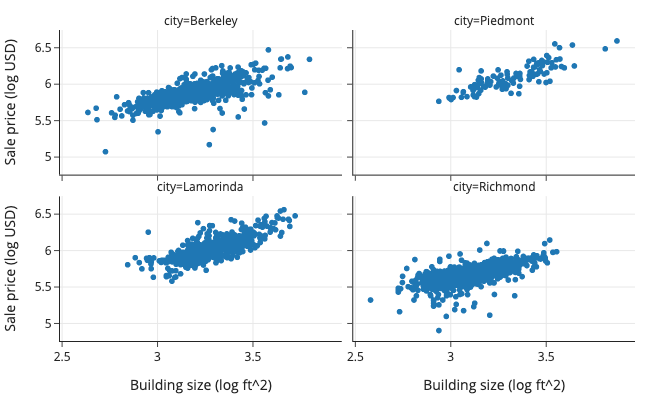

In [7]:
fig = px.scatter(sfh, x='log_bsqft', y='log_price', 
                 facet_col='city', facet_col_wrap=2,
                 labels={'log_bsqft':'Building size (log ft^2)',
                        'log_price':'Sale price (log USD)'},
                 width=500, height=400)

fig.update_layout(margin=dict(t=30))
fig

The shift is evident in the scatter plot. We concatenate our two design matrices together to fit the model that includes size and city: 

In [8]:
X_size = sfh['log_bsqft'] 

X_city_size = pd.concat([X_size.reset_index(drop=True), X_city_df], axis=1)
X_city_size.drop(0)

,log_bsqft,Berkeley,Lamorinda,Piedmont,Richmond
1,3.14,1.0,0.0,0.0,0.0
2,3.31,1.0,0.0,0.0,0.0
3,2.96,1.0,0.0,0.0,0.0
...,...,...,...,...,...
2664,3.16,0.0,0.0,0.0,1.0
2665,3.47,0.0,0.0,0.0,1.0
2666,3.44,0.0,0.0,0.0,1.0


Now let's fit a model that incorporates the quantitative feature, the house size, and the qualitative feature, location (city):

In [9]:
model_city_size = LinearRegression(fit_intercept=False).fit(X_city_size, y_log)

The intercepts reflect which cities have more expensive houses, even taking into account the size of the house:

In [155]:
model_city_size.coef_

array([0.62, 3.89, 3.98, 4.03, 3.75])

In [156]:
print(f"R-square for city and log(size):",
      f" {model_city_size.score(X_city_size, y_log):.2f}")

R-square for city and log(size):  0.79


This fit, which includes the nominal variable `city` and the log-transformed house size, is better than both the simple log–log model with house size and the model that fits constants for each city.

Notice that we dropped the intercept from the model so that each subgroup has its own intercept. 
However, a common practice is to remove one of the one-hot encoded features from the design matrix and keep the intercept. For example, if we drop the feature for Berkeley houses and add the intercept, then the model is:

$$
\theta_0 ~+~ \theta_1x_i ~+~ \theta_L x_{i,L} ~+~ \theta_P x_{i,P} ~+~ \theta_R x_{i,R}
$$

The meaning of the coefficients for the dummy variables has changed in this representation.
For example, consider this equation for a house in Berkeley and a house in Piedmont:

$$
\begin{aligned}
\theta_0 & ~+~ \theta_1x_i ~~&\text{for a house in Berkeley} \\
\theta_0 & ~+~ \theta_1x_i + \theta_P  ~~&\text{for a house in Piedmont}
\end{aligned}
$$

In this representation, the intercept $\theta_0$ is for Berkeley houses, and the coefficient $\theta_P$ measures the typical difference between a Piedmont house and a Berkeley house. In this representation, we can more easily compare 
$\theta_P$ to 0 to see if these two cities have essentially the same average price. 

If we include the intercept and all of the city variables, then 
the columns of the design matrix are linearly dependent, which means that we can't solve for the coefficients. Our predictions will be the same in either case, but there will not be a unique solution to the minimization.

We also prefer the representation of the model that drops one dummy variable and includes an intercept term when we  include one-hot encodings of two categorical variables. This practice maintains consistency in the interpretation of the coefficients.     

We demonstrate how to build a model with two sets of dummy variables, using the `statsmodels` library. This library uses a formula language to describe the model to fit, so we don't need to create the design matrix ourselves. We import the formula API, 

In [10]:
import statsmodels.formula.api as smf

Let's first repeat our fit of the model with the nominal variable `city` and house size to show how to use the formula language and compare the results: 

In [11]:
model_size_city = smf.ols(formula='log_price ~ log_bsqft + city',
                          data=sfh).fit()

The string provided for the `formula` parameter describes the model to fit. The model has `log_price` as the outcome and fits a linear combination of `log_bsqft` and `city` as explanatory variables. Notice that we do not need to create dummy variables to fit the model. Conveniently, `smf.ols` does the one-hot encoding of the city feature for us. The fitted coefficients of the following model, include an intercept term and drop the Berkeley indicator variable:

In [159]:
print(model_size_city.params)

Intercept            3.89
city[T.Lamorinda]    0.09
city[T.Piedmont]     0.14
city[T.Richmond]    -0.15
log_bsqft            0.62
dtype: float64


If we want to drop the intercept, we can add –1 to the formula, which is a convention that indicates dropping the column of ones from the design matrix. In this particular example, the space spanned by all of the one-hot encoded features is equivalent to the space spanned by the 1 vector and all but one of the dummy variables, so the fit is the same. However, the coefficients are different as they reflect the different parameterization of the design matrix: 

In [12]:
smf.ols(formula='log_price ~ log_bsqft + city - 1', data=sfh).fit().params

city[Berkeley]     3.89
city[Lamorinda]    3.98
city[Piedmont]     4.03
city[Richmond]     3.75
log_bsqft          0.62
dtype: float64

Additionally, we can add interaction terms between the city and size variables to allow each city to have a different coefficient for size. We specify this in the formula by adding the term `log_bsqft:city`. We don't go into details here.

Now let's fit a model with two categorical variables: the number of bedrooms and the city. Recall that we earlier reassigned the count of bedrooms that were above 6 to 6, which essentially collapses 6, 7, 8, ... into the category, 6+. We can see this relationship in the box plots of price (log \$) by the number of bedrooms: 

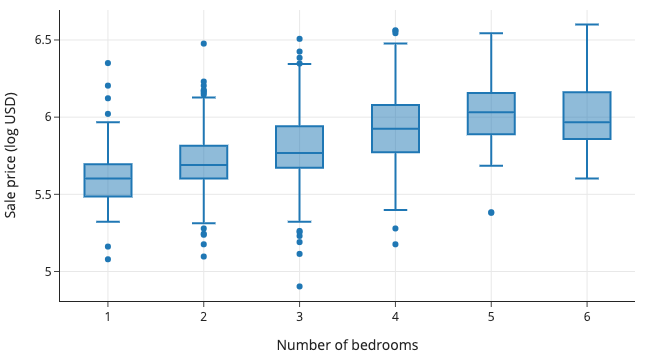

In [15]:
px.box(sfh, x="br", y="log_price", width=450, height=250,
      labels={'br':'Number of bedrooms','log_price':'Sale price (log USD)'})

The relationship does not appear linear: for each additional bedroom, the sale price does not increase by the same amount. Given that the number of bedrooms is discrete, we can treat this feature as categorical, which allows each bedroom encoding to contribute a different amount to the cost:

In [16]:
model_size_city_br = smf.ols(formula='log_price ~ log_bsqft + city + C(br)',
                             data=sfh).fit()

We have used the term `C(br)` in the formula to indicate that we want the number of bedrooms, which is numeric, to be treated like a categorical variable. 

Let’s examine the multiple $R^2$ from the fit:

In [17]:
model_size_city_br.rsquared.round(2)

0.79

The multiple $R^2$ has not increased even though we have added five more one-hot encoded features. The $R^2$ is adjusted for the number of parameters in the model and by this measure
is no better than the earlier one that included only city and size.

In this section, we introduced feature engineering for qualitative features. We saw how the one-hot encoding technique lets us include categorical data in linear models and gives a natural interpretation for model parameters.